# Importing libs

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# ! rm -rf /kaggle/working/data/

In [8]:
data_dir_train = pathlib.Path("/kaggle/input/dataset-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/kaggle/input/dataset-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Prepare Dataset

In [10]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


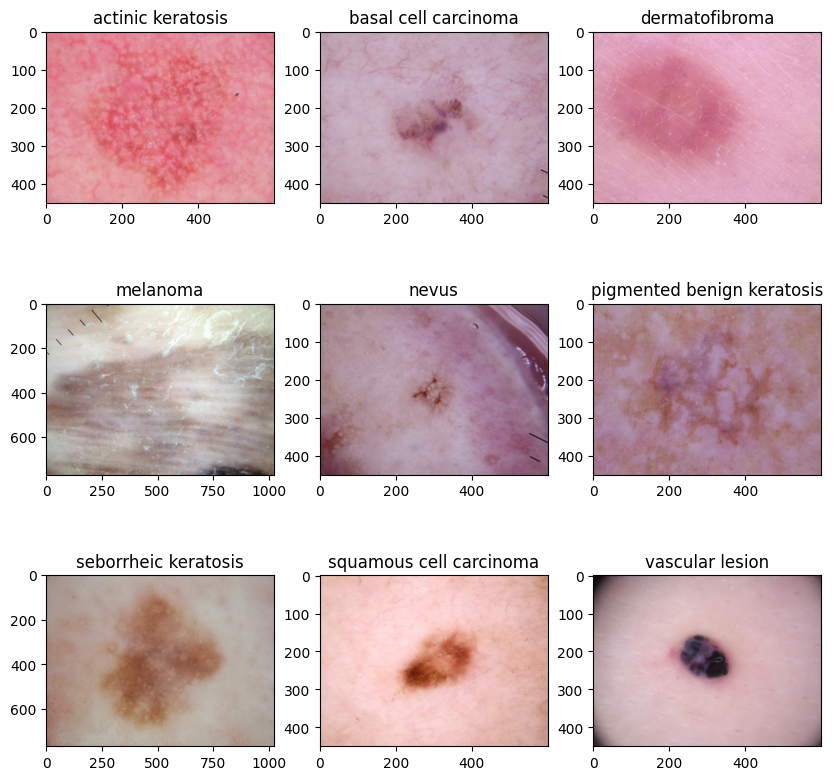

In [15]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [16]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model 1

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling

num_classes = 9
img_height, img_width = 180, 180

model = Sequential([
    Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
    
    Conv2D(32, 3, padding="same", activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding="same", activation='relu'),
    MaxPooling2D(),
    
    Conv2D(128, 3, padding="same", activation='relu'),
    MaxPooling2D(),
    
    Conv2D(256, 3, padding="same", activation='relu'),
    MaxPooling2D(),
    
    Conv2D(512, 3, padding="same", activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    Dense(1024, activation="relu"),
    Dense(units=num_classes, activation='softmax')
])

In [20]:
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)

model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,686,025 (56.02 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25


2024-03-22 03:46:27.635491: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32579: 2.52773, expected 2.17065
2024-03-22 03:46:27.635697: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64800: 3.42914, expected 2.63773
2024-03-22 03:46:27.635708: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64801: 4.47085, expected 3.67943
2024-03-22 03:46:27.635716: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64802: 5.17326, expected 4.38184
2024-03-22 03:46:27.635724: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64803: 4.62295, expected 3.83154
2024-03-22 03:46:27.635731: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64804: 4.59479, expected 3.80337
2024-03-22 03:46:27.635745: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64805: 5.65862, expected 4.86721
2024-03-22 03:46:27.635753:

 6/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2122 - loss: 2.2832 

I0000 00:00:1711079193.798868      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711079193.819999      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2063 - loss: 2.1489

W0000 00:00:1711079198.280539      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-03-22 03:46:39.153543: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.95802, expected 2.10118
2024-03-22 03:46:39.153623: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.53537, expected 3.67853
2024-03-22 03:46:39.153639: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.59043, expected 3.73359
2024-03-22 03:46:39.153657: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.05404, expected 4.1972
2024-03-22 03:46:39.153669: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.09664, expected 4.2398
2024-03-22 03:46:39.153679: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.43808, expected 3.58124
2024-03-22 03:46:39.153690: E external/local_xla/xla/service/gpu/bu

56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 131ms/step - accuracy: 0.2060 - loss: 2.1450 - val_accuracy: 0.2058 - val_loss: 2.1043
Epoch 2/25
 7/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1825 - loss: 2.1095

W0000 00:00:1711079201.035146      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2497 - loss: 2.0273 - val_accuracy: 0.3624 - val_loss: 1.7970
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3331 - loss: 1.8333 - val_accuracy: 0.3468 - val_loss: 1.7971
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4008 - loss: 1.6708 - val_accuracy: 0.4832 - val_loss: 1.5062
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4703 - loss: 1.5285 - val_accuracy: 0.4877 - val_loss: 1.5530
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4545 - loss: 1.5516 - val_accuracy: 0.5056 - val_loss: 1.4906
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5012 - loss: 1.4372 - val_accuracy: 0.5145 - val_loss: 1.4283
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5339 - loss: 1.3615 - val_accuracy: 0.5056 - val_loss: 1.6282
Epoch 9/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5402 - loss: 1.3359 - val_accuracy: 0.4586 - val_loss: 1.

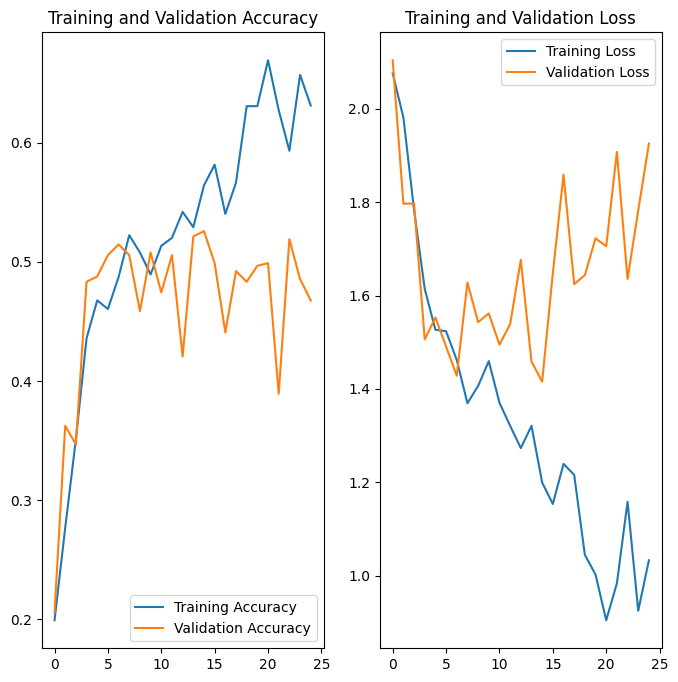

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 2 : Data Augumentation with drop out layer

In [24]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical", 
                           input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ]
)

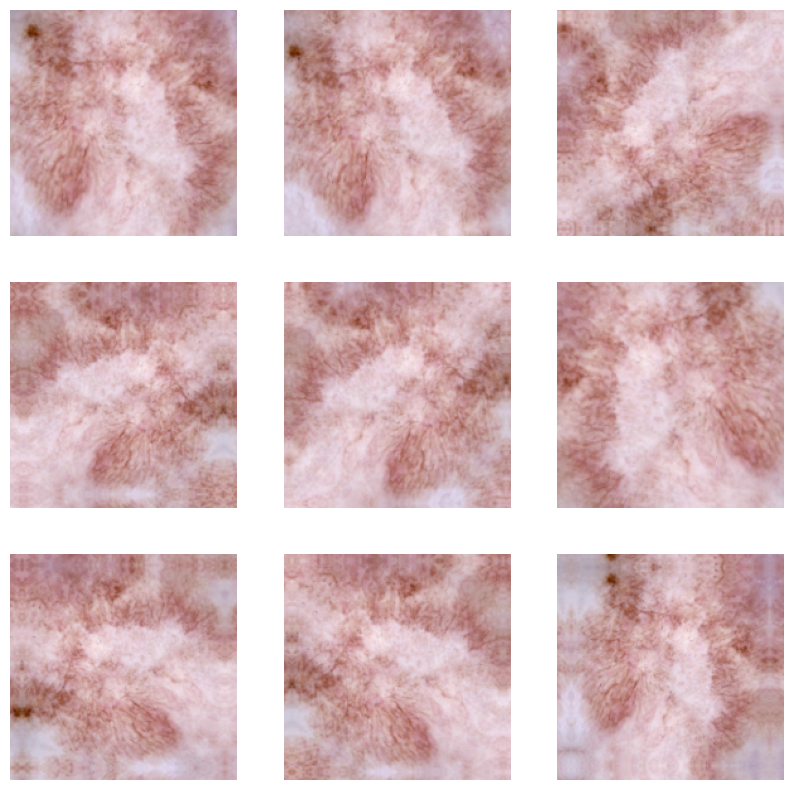

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [26]:
num_classes = 9
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1.0/255,input_shape=(img_height,img_width,3)))

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [27]:
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25


2024-03-22 03:49:02.055179: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.1824 - loss: 2.1630 - val_accuracy: 0.2371 - val_loss: 1.9710
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2560 - loss: 1.9287 - val_accuracy: 0.2998 - val_loss: 1.8721
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3394 - loss: 1.7439 - val_accuracy: 0.4139 - val_loss: 1.6279
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4065 - loss: 1.6375 - val_accuracy: 0.4765 - val_loss: 1.5433
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4318 - loss: 1.6300 - val_accuracy: 0.4944 - val_loss: 1.5134
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4742 - loss: 1.4535 - val_accuracy: 0.5190 - val_loss: 1.4701
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4683 - loss: 1.4507 - val_accuracy: 0.4989 - val_loss: 1.4907
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4832 - loss: 1.4359 - val_accuracy: 0.4855 - val_loss: 1.

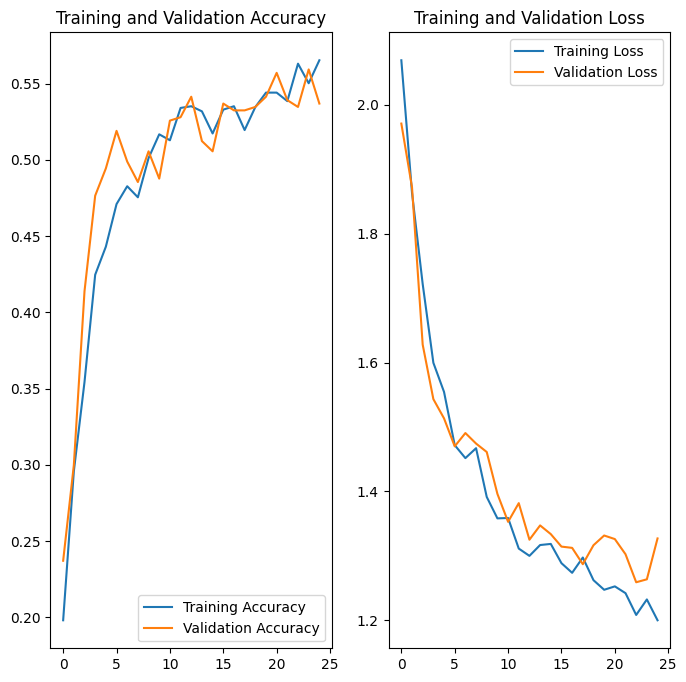

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Analyzing the class imbalance of data

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

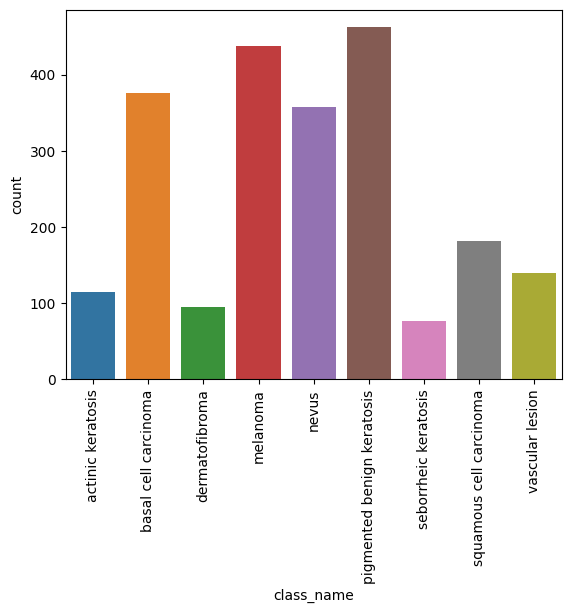

In [25]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

# Augmentor : Class balance

In [30]:
!pip install Augmentor

In [31]:
path_to_training_dataset = '../input/dataset-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/data/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/data/actinic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79C20827FA90>: 100%|██████████| 500/500 [00:06<00:00, 81.06 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/data/basal cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79C644128DF0>: 100%|██████████| 500/500 [00:06<00:00, 77.62 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/data/dermatofibroma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79C6102F1BA0>: 100%|██████████| 500/500 [00:06<00:00, 75.37 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/data/melanoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x79C64447D030>: 100%|██████████| 500/500 [00:36<00:00, 13.66 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/data/nevus/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x79C64429CCD0>: 100%|██████████| 500/500 [00:29<00:00, 16.93 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/data/pigmented benign keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79C6443E0F10>: 100%|██████████| 500/500 [00:06<00:00, 76.47 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/data/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79C61013B460>: 100%|██████████| 500/500 [00:14<00:00, 33.49 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/data/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79C6101D8BB0>: 100%|██████████| 500/500 [00:06<00:00, 81.55 Samples/s]                   


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/data/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79C6102743A0>: 100%|██████████| 500/500 [00:06<00:00, 81.23 Samples/s]                  


In [32]:
output_dir = pathlib.Path('/kaggle/working/data/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


total training image count = 4500 

-------------------------------------
Class name =  actinic keratosis
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  500
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  500
proportion =  0.1111111111111111

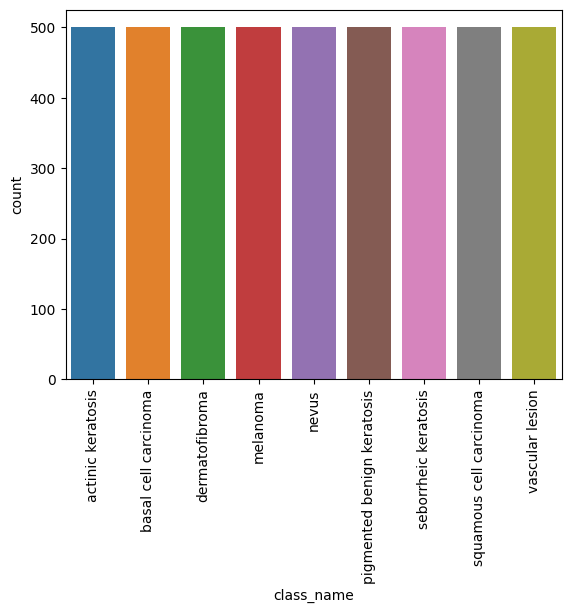

In [33]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

# Model 3: with Balanced Classes

In [52]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [53]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [54]:
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [55]:
num_classes = 9
img_height, img_width = 180, 180

model = Sequential([
    Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),
    Conv2D(32, 3, padding="same", activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding="same", activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding="same", activation='relu'),
    MaxPooling2D(),
    Dropout(0.15),
    Conv2D(256, 3, padding="same", activation='relu'),
    MaxPooling2D(),
    Dropout(0.20),
    Conv2D(512, 3, padding="same", activation='relu'),
    MaxPooling2D(),
    Dropout(0.30),
    Flatten(),
    Dense(1024, activation="relu"),
    Dense(units=num_classes, activation='softmax')
])

In [56]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,686,025 (56.02 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
learning_rate = 0.0001
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
  7/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.1355 - loss: 2.2332

W0000 00:00:1711080662.717894      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.1456 - loss: 2.1614

W0000 00:00:1711080682.118854      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711080683.038529      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 192ms/step - accuracy: 0.1460 - loss: 2.1602 - val_accuracy: 0.2589 - val_loss: 1.7792
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.3145 - loss: 1.7548 - val_accuracy: 0.3722 - val_loss: 1.5412
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.4028 - loss: 1.5433 - val_accuracy: 0.4300 - val_loss: 1.4347
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.4608 - loss: 1.3980 - val_accuracy: 0.4767 - val_loss: 1.3636
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.4795 - loss: 1.3486 - val_accuracy: 0.5156 - val_loss: 1.3141
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.5427 - loss: 1.2468 - val_accuracy: 0.5600 - val_loss: 1.2130
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5707 - loss: 1.1531 - val_accuracy: 0.5511 - val_loss: 1.2064
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6014 - loss: 1.0900 - val_accuracy: 0.5

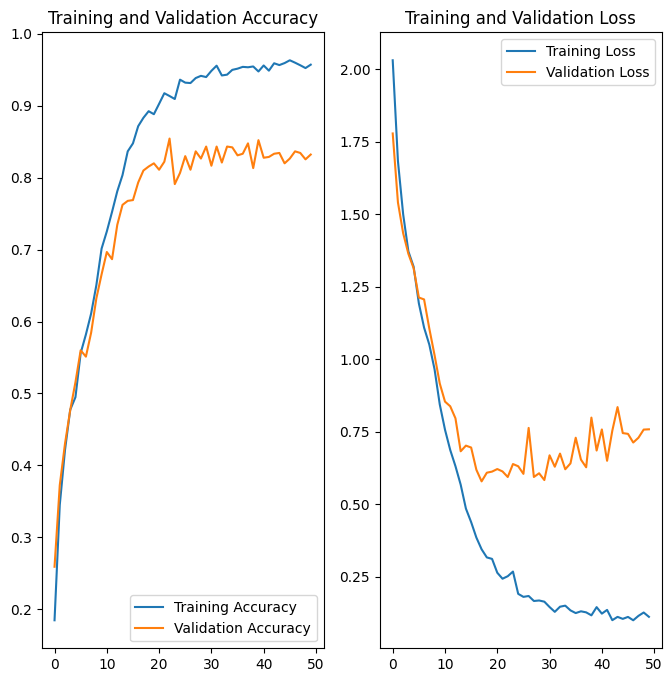

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluation

In [60]:
model_path = '/kaggle/working/cnn_model.h5'

model.save(model_path)

In [61]:
(eval_loss, eval_accuracy) = model.evaluate(val_ds, batch_size=batch_size, \
                                            verbose=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8311 - loss: 0.7881


In [62]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,058,077 (168.07 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,372,052 (112.05 MB)

In [63]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 

[INFO] accuracy: 83.22%
[INFO] Loss: 0.7572398781776428


In [70]:
import cv2
from tensorflow.keras.models import load_model
model_path = '/kaggle/working/cnn_model.h5' 

model = load_model(model_path)

img_height, img_width = 180, 180 

sample_image_path = '/kaggle/input/dataset-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000141.jpg'

sample_image = cv2.imread(sample_image_path)
sample_image = cv2.resize(sample_image, (img_width, img_height))  
sample_image = sample_image / 255.0  
sample_image = np.expand_dims(sample_image, axis=0) 

predictions = model.predict(sample_image)

predicted_class_index = np.argmax(predictions)

class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

predicted_class_name = class_names[predicted_class_index]

print("Predicted class:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
Predicted class: melanoma
